In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import codedapertures as ca
import scipy as sp
import os


from utils import get_objects_from_config
from experiment import CodApSimulator, play_simulation
from image_preprocessing import process_image

# <center> First attempt on simulating Coded Aperture (DEPRECATED) </center>

This notebook is a first attempt on simulating light coming out of a screen as single photons, passing through a single hole, projecting onto a flat sensor.

The degrees of fredom would be:
1. Distance between each screen
2. Solid angle limits of emision (for now, we fix it at 360 for $\theta$, and 90 for $\phi$)
3. Number of photons coming out of each pixel
4. Resolution: Number of pixels on the light source
5. Dimention of each screen

For now, 1, 4 and 5 will be fixed.

# Testing Image Prepocessing

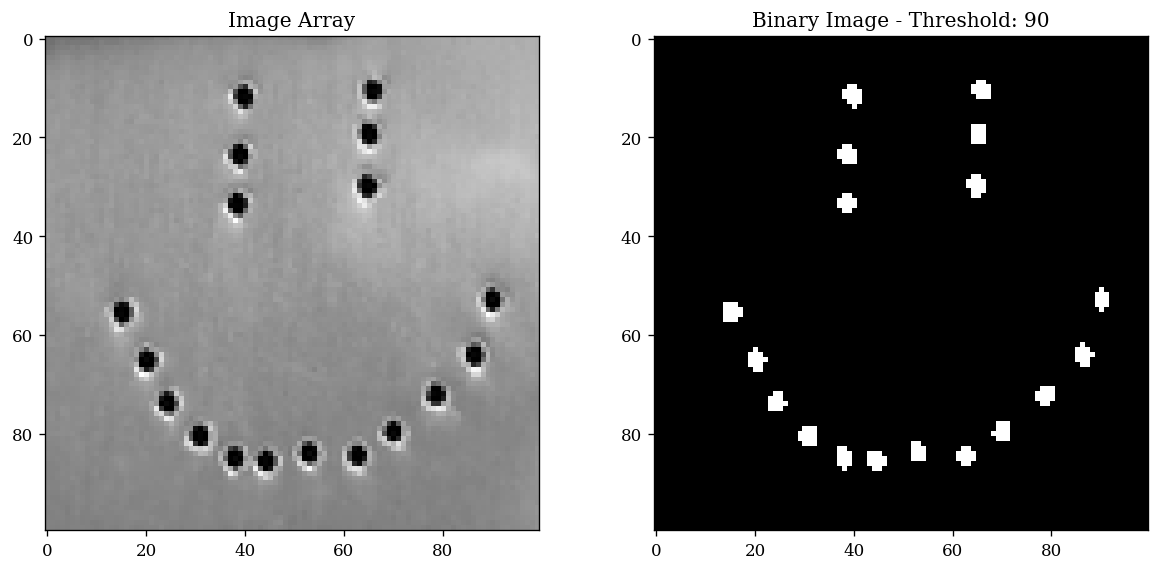

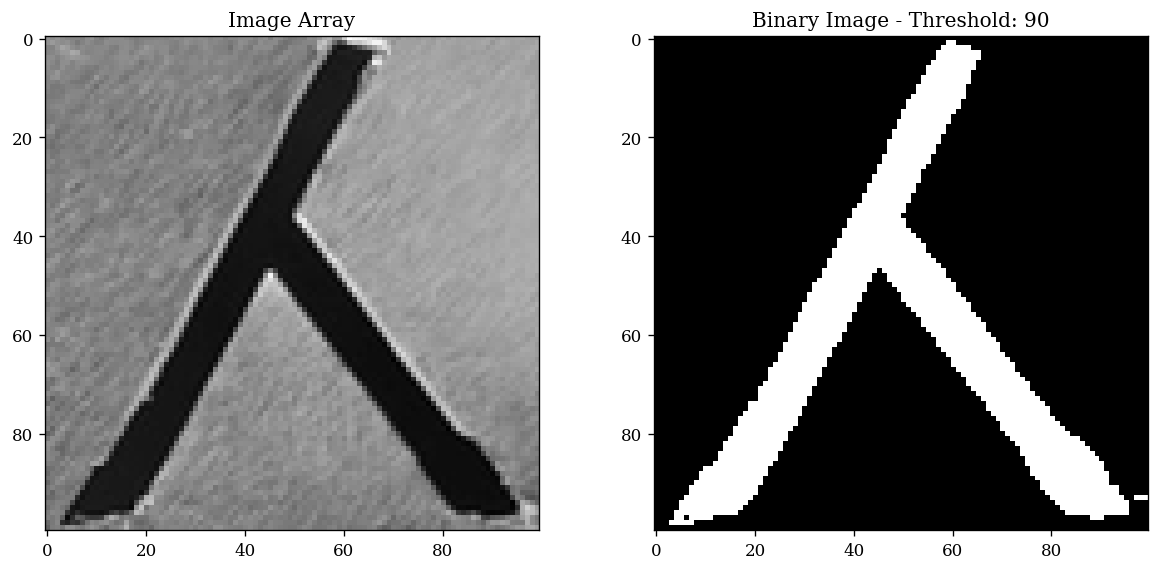

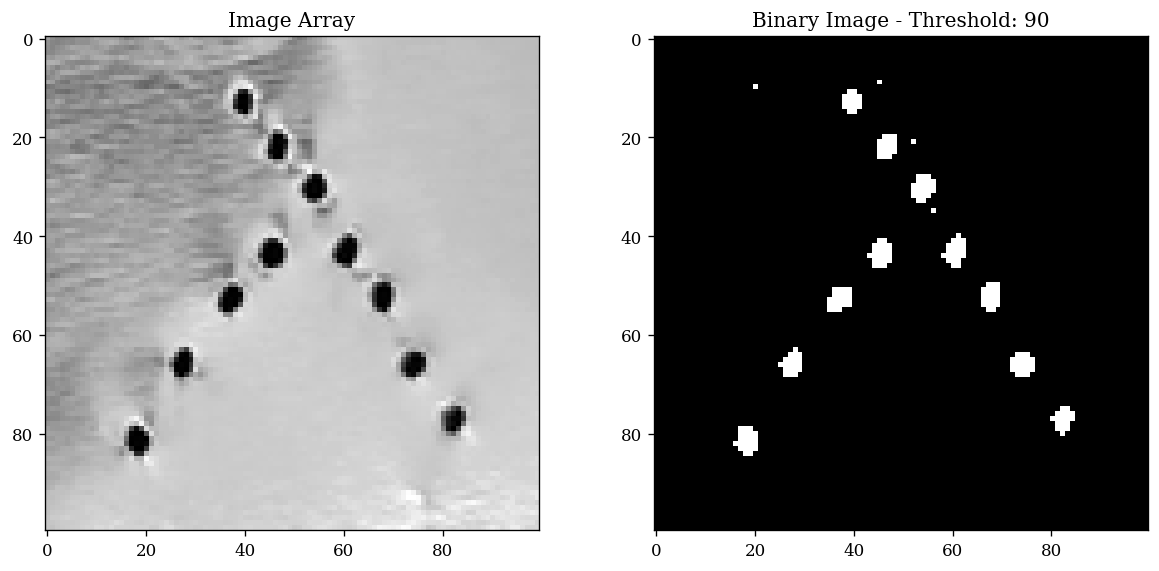

In [2]:
names = ['face_pinhole', 'lambda_letter_srce', 'lambda_letter_pinhole']
for i in range(len(names)):
    binary_img = process_image(names[i], type=types[i], invert = True)

# Testing full pipeline

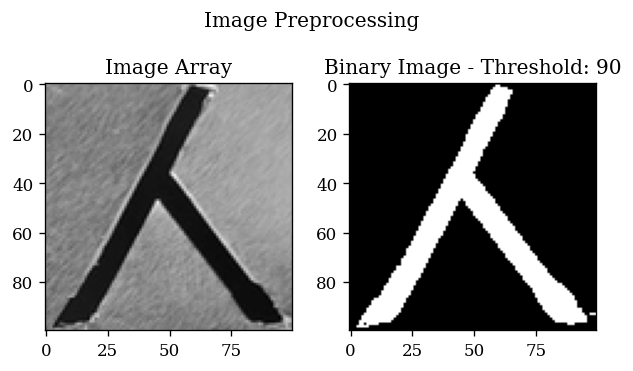

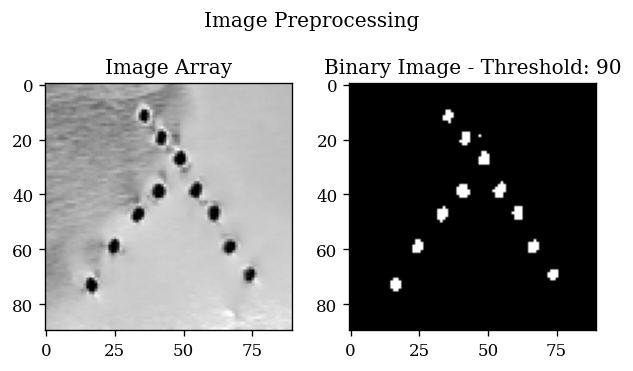

The chosen directory is not empty:
results\Test 2


  1%|          | 307/50000 [00:00<00:35, 1394.02it/s]

Continuing...
Simulating the propagation of photons through the slit...


100%|██████████| 50000/50000 [00:26<00:00, 1876.13it/s]

Adding noise to the image...
Done!
Saving results...


In [13]:
config_path = "config.json"
source, slit, sensor, options = get_objects_from_config(config_path)
simulator = CodApSimulator(options=options, source=source, slit=slit, sensor=sensor)
play_simulation(simulator=simulator, config_path='config.json')

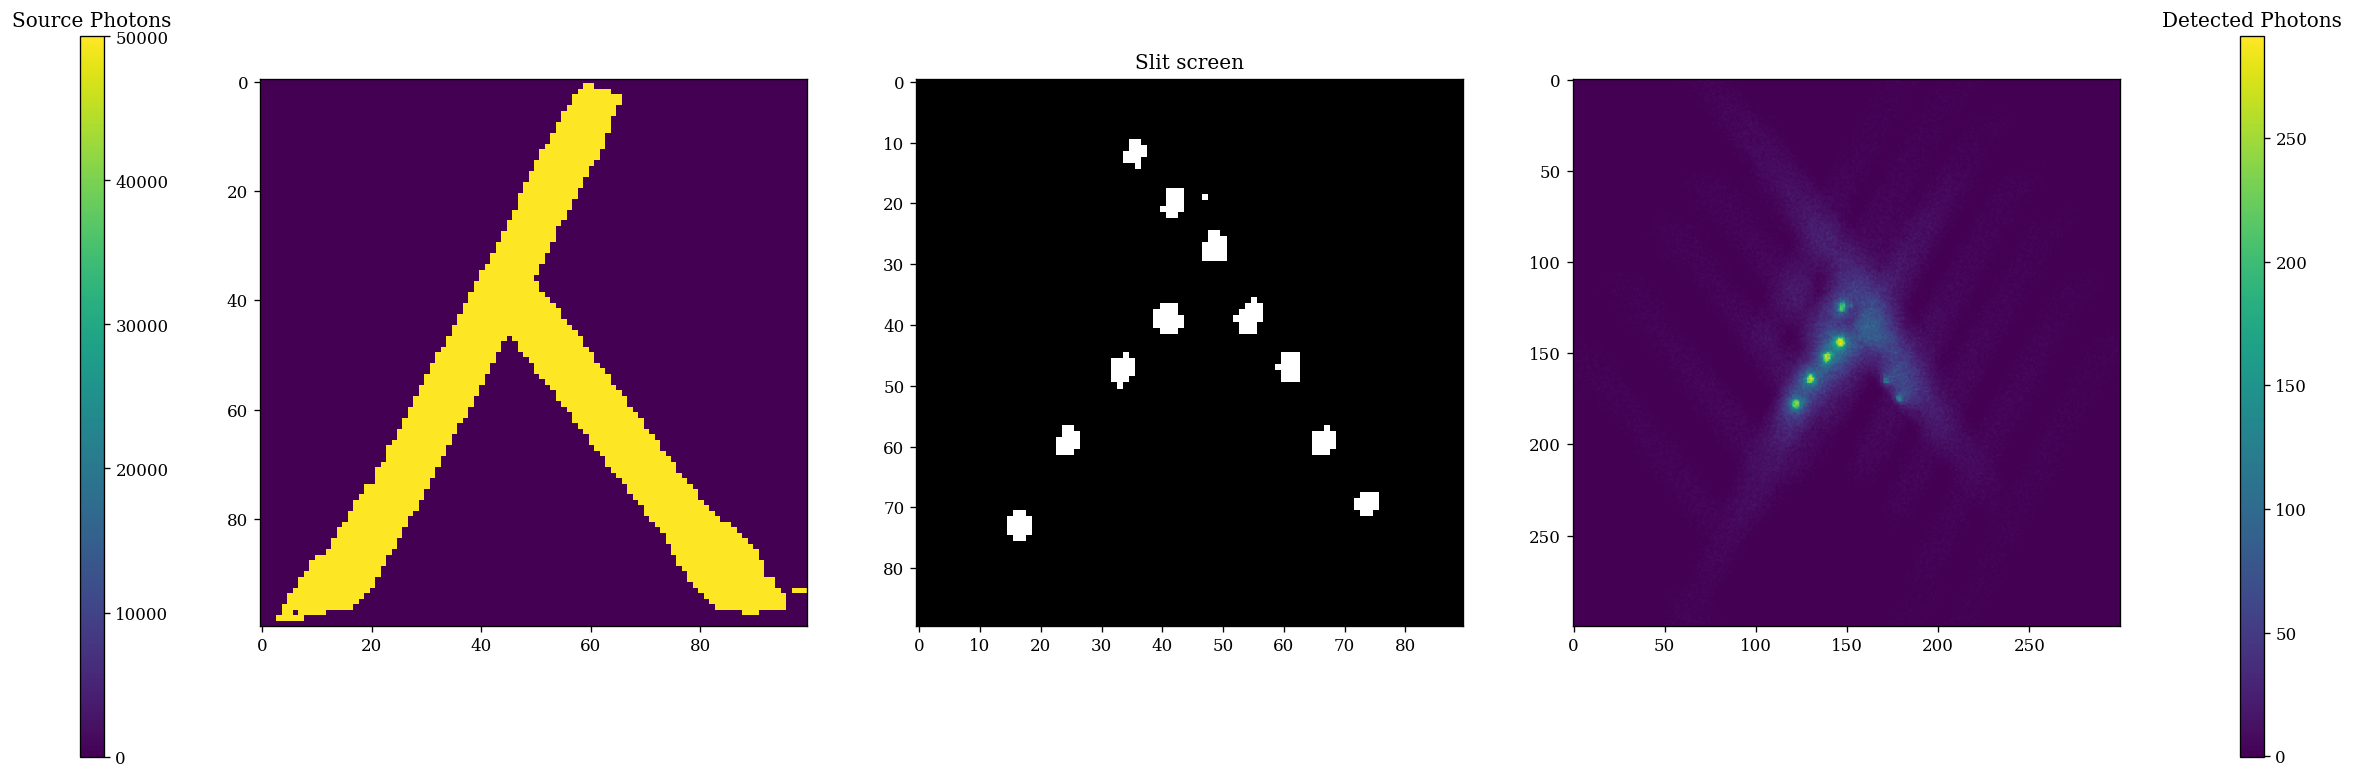

In [14]:
fig = plt.figure(figsize=(20, 20))
plt.subplot(2,3, 1)
vmin, vmax = 0, float(np.max(simulator.source.screen))
im = plt.imshow(simulator.source.screen, vmin=vmin, vmax=vmax)
im = plt.imshow(simulator.source.screen)
cbar_ax = fig.add_axes([0.05, 0.54, 0.01, 0.3])
fig.colorbar(im, cax=cbar_ax)
plt.title("Source Photons")
plt.subplot(2, 3, 2)
plt.imshow(simulator.slit.mask, cmap="binary_r")
plt.title("Slit screen")
plt.subplot(2, 3, 3)
vmin, vmax = 0, float(np.percentile(simulator.sensor.screen, 99.9))
im = plt.imshow(simulator.sensor.screen, vmin=vmin, vmax=vmax)
im = plt.imshow(simulator.sensor.screen)
cbar_ax = fig.add_axes([0.95, 0.54, 0.01, 0.3])
fig.colorbar(im, cax=cbar_ax)
plt.title("Detected Photons")
plt.savefig(os.path.join(simulator.saving_dir, "results.png"))

In [30]:
config_path = "config.json"
source, slit, sensor, options = get_objects_from_config(config_path)
simulator = CodApSimulator(options=options, source=source, slit=slit, sensor=sensor)
play_simulation(simulator=simulator, config_path='config.json')

The chosen directory is not empty:
results\Test 2


  1%|          | 122/10000 [00:00<00:08, 1169.39it/s]

Continuing...
Simulating the propagation of photons through the slit...


100%|██████████| 10000/10000 [00:06<00:00, 1649.55it/s]

Adding noise to the image...
Done!
Saving results...


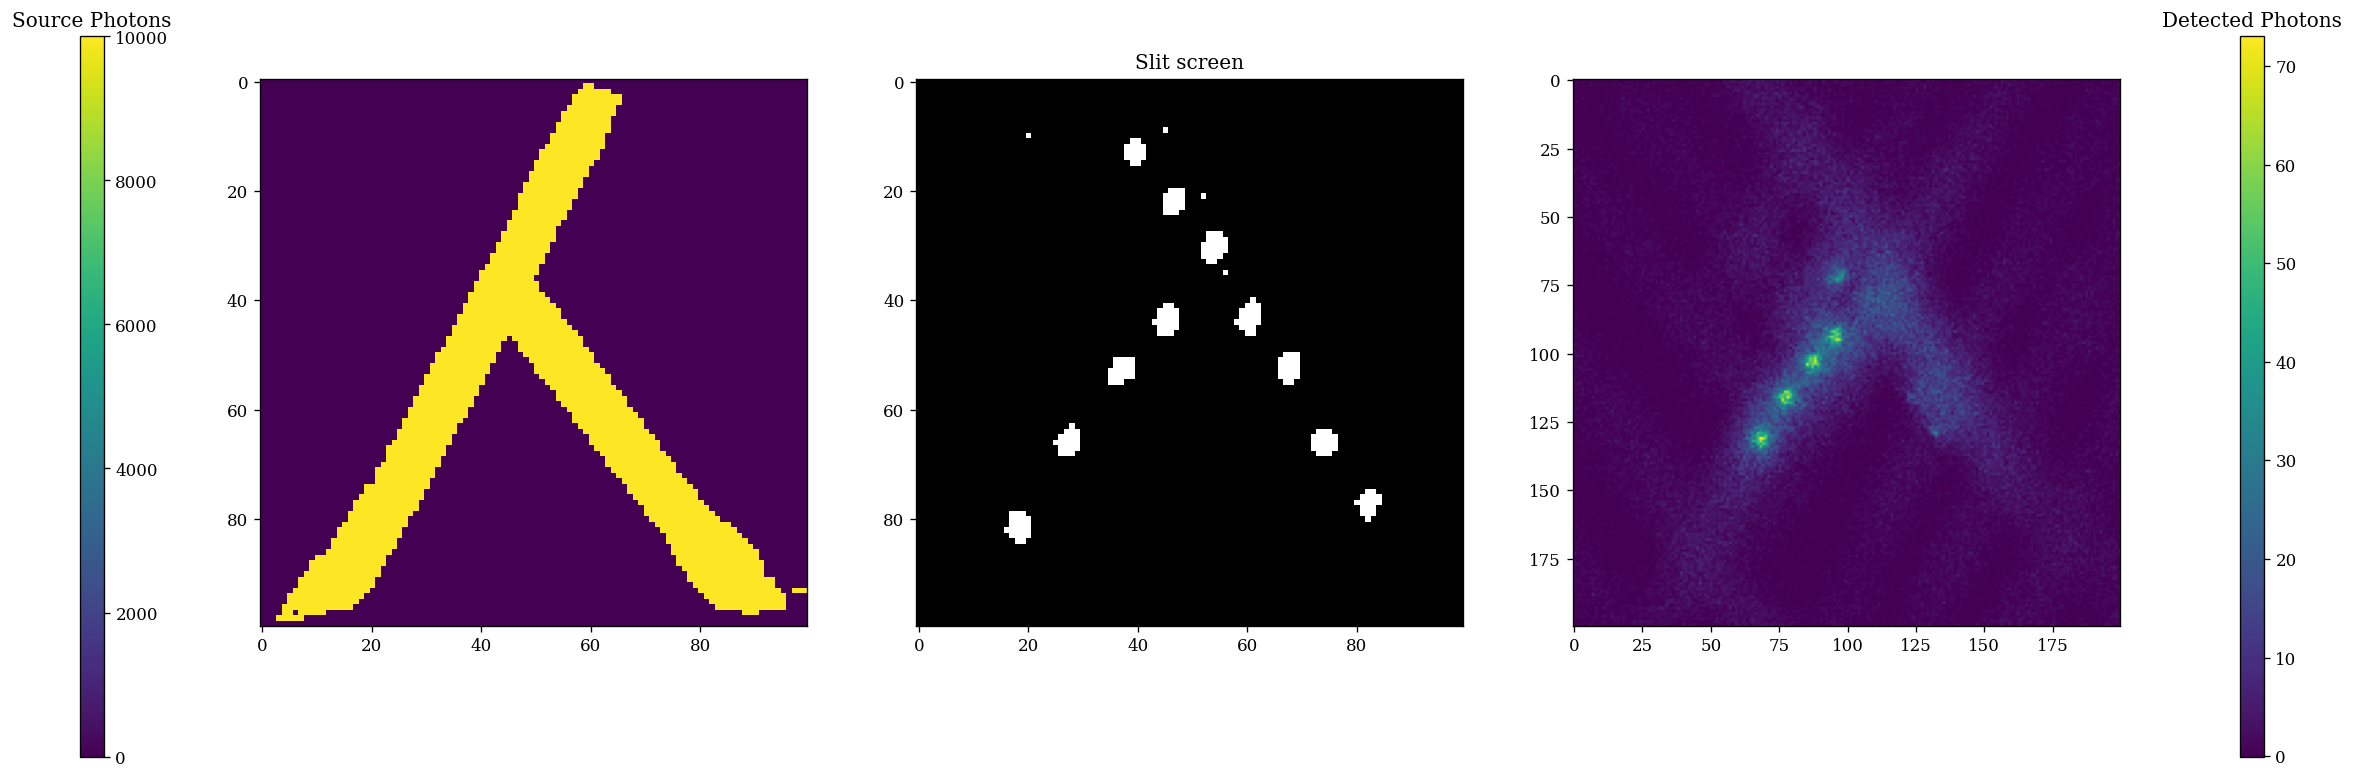

In [31]:
fig = plt.figure(figsize=(20, 20))
plt.subplot(2,3, 1)
vmin, vmax = 0, float(np.max(simulator.source.screen))
im = plt.imshow(simulator.source.screen, vmin=vmin, vmax=vmax)
im = plt.imshow(simulator.source.screen)
cbar_ax = fig.add_axes([0.05, 0.54, 0.01, 0.3])
fig.colorbar(im, cax=cbar_ax)
plt.title("Source Photons")
plt.subplot(2, 3, 2)
plt.imshow(simulator.slit.mask, cmap="binary_r")
plt.title("Slit screen")
plt.subplot(2, 3, 3)
vmin, vmax = 0, float(np.percentile(simulator.sensor.screen, 99.9))
im = plt.imshow(simulator.sensor.screen, vmin=vmin, vmax=vmax)
im = plt.imshow(simulator.sensor.screen)
cbar_ax = fig.add_axes([0.95, 0.54, 0.01, 0.3])
fig.colorbar(im, cax=cbar_ax)
plt.title("Detected Photons")
plt.savefig(os.path.join(simulator.saving_dir, "results.png"))

# Testing Decoding

## MURA

In [3]:
config_path = 'mura_experiment.json'
source, slit, sensor, options = get_objects_from_config(config_path=config_path)
simulator = CodApSimulator(source=source, slit=slit, sensor=sensor, options=options)

Modified Uniformly Redundant Array
----------------------------------
rank:   11
L:      101
tile:   (1, 1)
width:  101
height: 101
The chosen directory is not empty:
results/phi | mura | skipper 2
Continuing...


In [4]:
play_simulation(simulator=simulator, config_path='config.json')

Simulating the propagation of photons through the slit...


100%|██████████| 10000/10000 [00:03<00:00, 2823.08it/s]


Adding noise to the image...
decoding mura image...
Done!
Saving results...


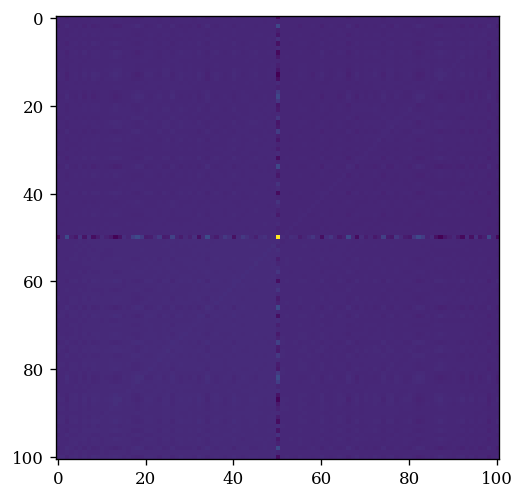

In [19]:
plt.imshow(sp.signal.correlate(simulator.slit.mask, simulator.decoding_pattern, mode='same'))

Modified Uniformly Redundant Array
----------------------------------
rank:   2
L:      17
tile:   (1, 1)
width:  17
height: 17


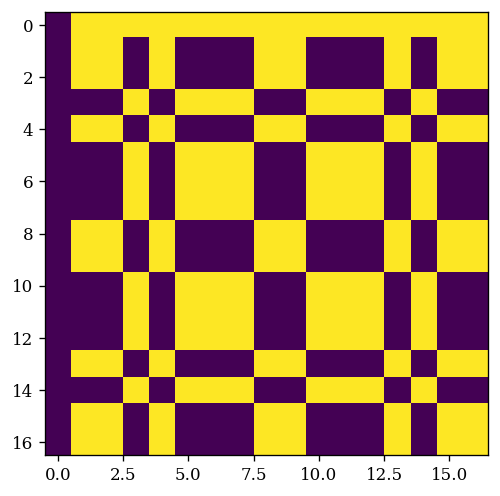

In [32]:
mura = ca.mura(rank=2, tile=1)
plt.imshow(mura.aperture)

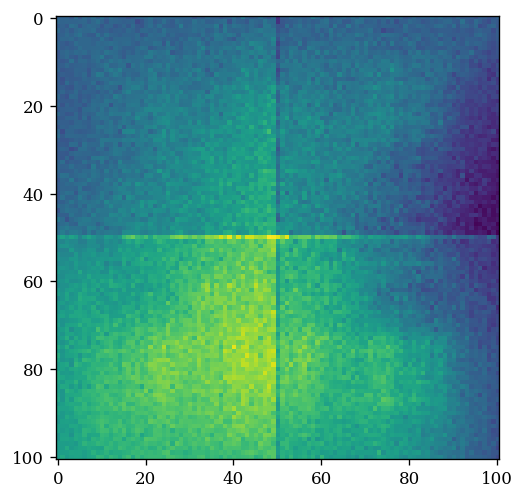

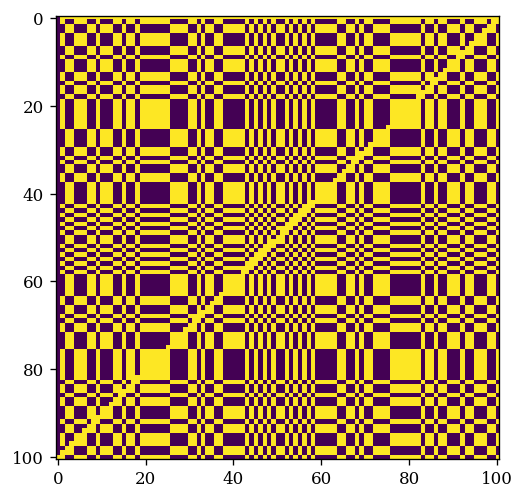

In [18]:
plt.imshow(sp.signal.correlate(simulator.sensor.screen, simulator.decoding_pattern, mode='same'))
plt.show()
plt.imshow(simulator.decoding_pattern)

## Inverse Filering ([image restoration with inverse filtering](https://vkhoi.github.io/notes/image-restoration-with-inverse-filtering))

In [3]:
import cv2
import math
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import fftpack
from scipy import signal
from scipy.ndimage.filters import convolve

%matplotlib inline


/var/folders/m6/dj2mn85s7jg_r9ptl4kt_6q80000gn/T/ipykernel_41826/4095316728.py:8: DeprecationWarning: Please use `convolve` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import convolve


In [4]:
# Display grayscale image.
def displayImage(img):
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(1, 1, 1)
    ax.imshow(img, cmap='gray')

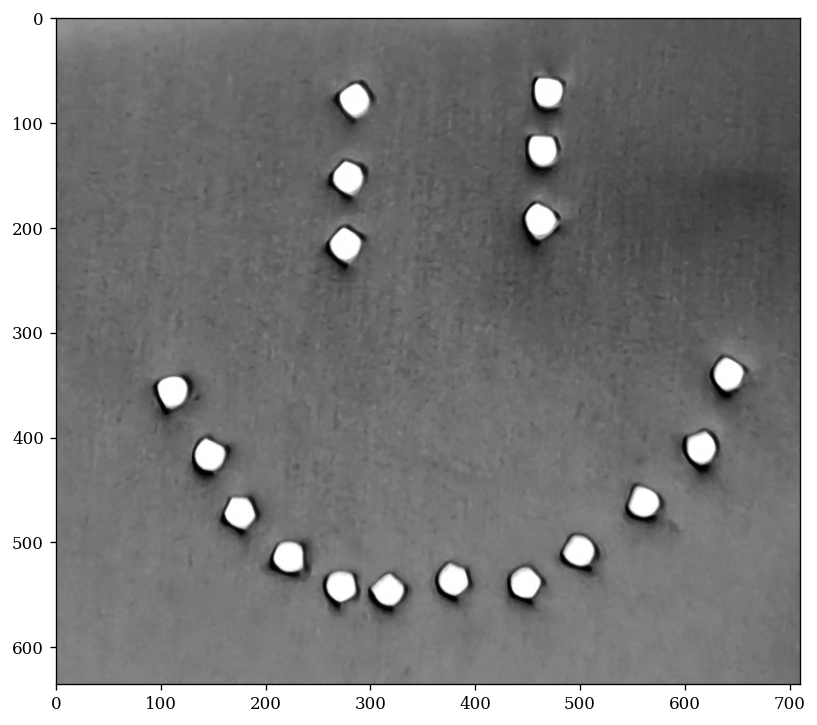

In [23]:
# Input image.
IMAGE_NAME = 'exp_pics/face_pinhole_exp.png'
img = cv2.imread(IMAGE_NAME, 0)
# Invert image.
img = 255 - img

# Display image.
displayImage(img)

Modified Uniformly Redundant Array
----------------------------------
rank:   4
L:      37
tile:   (1, 1)
width:  37
height: 37


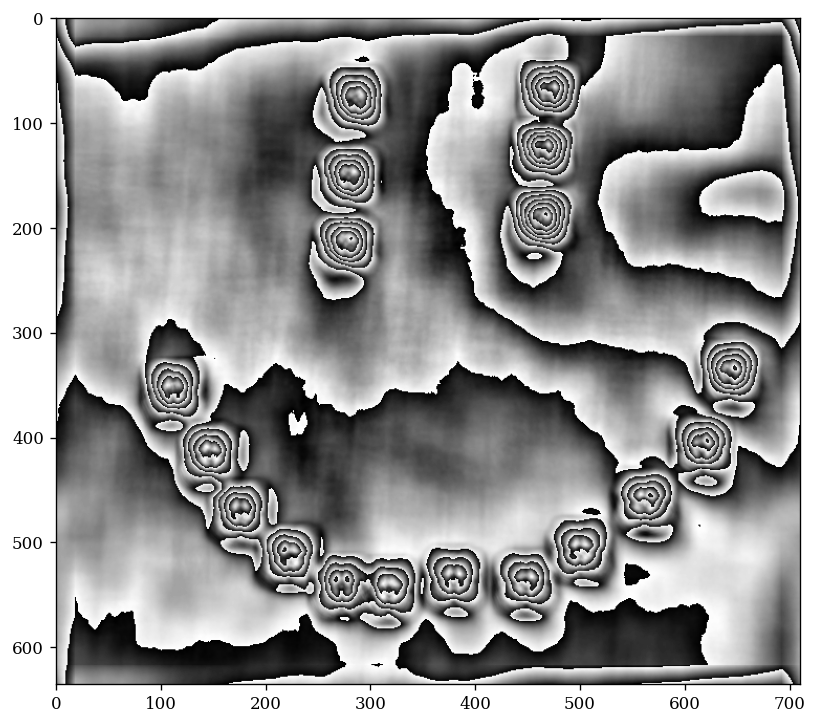

In [35]:
H = 37 # Height of the image.
mura = ca.mura(rank=4, tile=None, center=True)
h = mura.aperture / 37

# Apply onto the image.
g = convolve(img, h, mode='wrap')
displayImage(g)

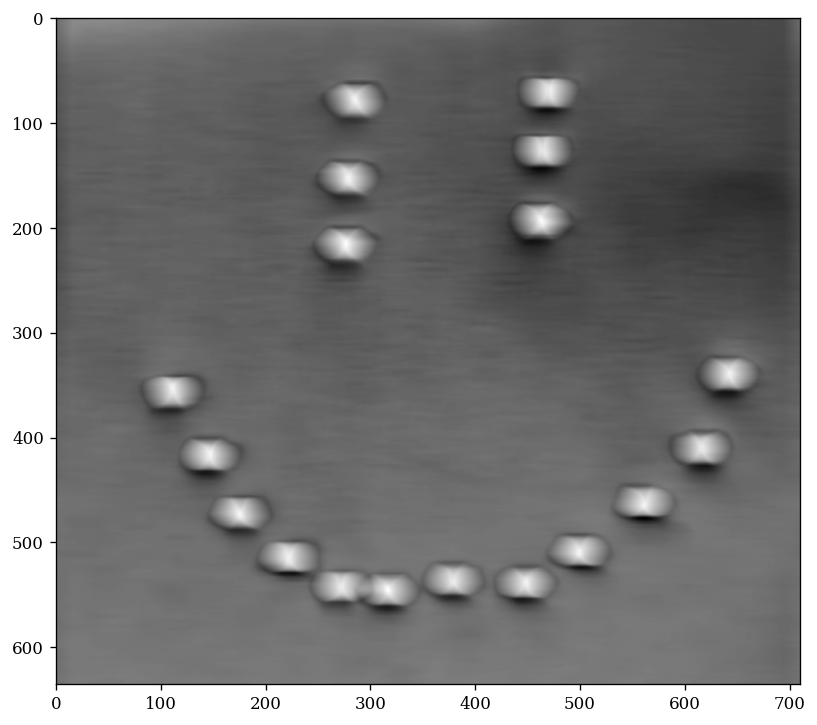

In [34]:
# # Create motion blur filter with size K.
# K = 31
# h = np.zeros((K, K))
# h[K//2,:] = np.ones(K) / K

# # Apply onto the image.
# g = convolve(img, h, mode='wrap')
# displayImage(g)

In [36]:
M = g.shape[0]
N = g.shape[1]

# Pad the filter with 0.
h_pad = np.zeros((M, N))
h_pad[(M-h.shape[0])//2:(M-h.shape[0])//2+h.shape[0],(N-h.shape[1])//2:(N-h.shape[1])//2+h.shape[1]] = h

# Shift the filter so that its center lies at the first element, aka H[0,0].
h_pad = scipy.fftpack.ifftshift(h_pad)

In [37]:
G = scipy.fftpack.fft2(g)
H = scipy.fftpack.fft2(h_pad)

/var/folders/m6/dj2mn85s7jg_r9ptl4kt_6q80000gn/T/ipykernel_41826/2595350236.py:5: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  H_inv = np.zeros(G.shape, dtype=np.complex)


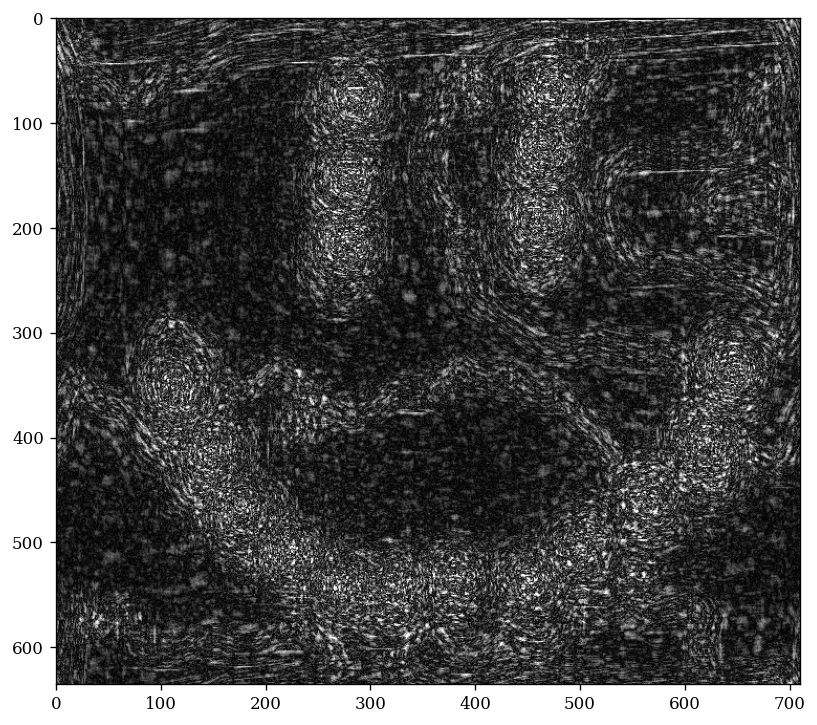

In [46]:
# Set threshold to 0.005.
threshold = 0.35

# Create array to store the pseudo-inverse filter.
H_inv = np.zeros(G.shape, dtype=np.complex)

for r in range(H.shape[0]):
    for c in range(H.shape[1]):
    	# Compute the magnitude and compare it with threshold.
        mag = np.abs(H[r,c])
        if mag <= threshold:
            H_inv[r,c] = 0
        else:
            H_inv[r,c] = 1.0 / H[r,c]

# Compute the approximated Fourier transform of the original image.
F = G * H_inv

# Inverse the Fourier transform to get the original image.
f = scipy.fftpack.ifft2(F)
f = np.abs(f)

# Some values are larger than 255, so we clamp it to 255.
for r in range(f.shape[0]):
    for c in range(f.shape[1]):
        if f[r,c] > 255:
            f[r,c] = 255
displayImage(f)